# Example Usage of EQTransformer from seisbench
This notebook is mostly an uncommented version of the “03a_training_phasenet” notebook from the seisbench repository.

In [1]:
import seisbench.generate as sbg
import seisbench.models as sbm

from seisbench.data import WaveformDataset
from seisbench.models import EQTransformer
from seisbench.util import worker_seeding

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

import pandas as pd
from utils import preprocess


Load the 100Samples dataset from the EQTransformer repository but transformed into seisbench-compatible format.

Rename the label columns.

Perform (minimal) data augmentation.  I assume (but did not test) that `ChangeDtype` is necessary for the code to run; `ProbabilisticLabeller` provides the probability curves below, but I do not know how they are calculated.

In [2]:
batch_size = 1000 #
num_workers = 24  # The number of threads used for loading data

data = WaveformDataset("data/STEAD/example/seisbench")

train_loader, dev_loader, test_loader = preprocess(data, batch_size, num_workers)


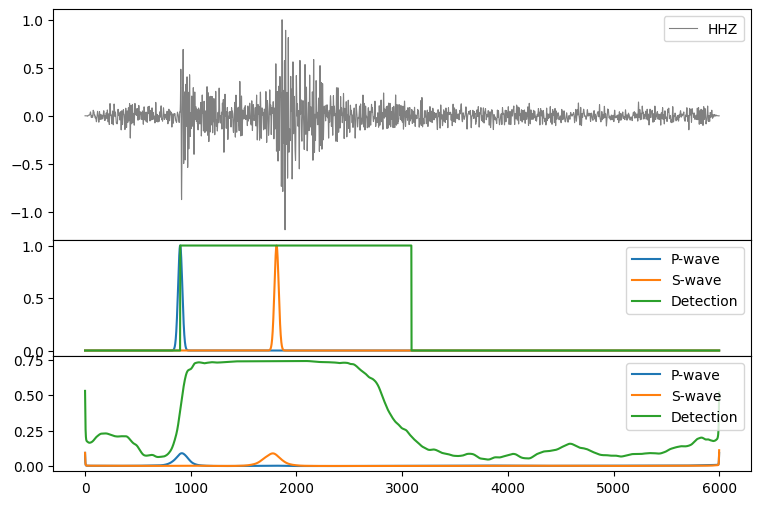

In [5]:
from swag.posteriors import SWAG

dataset = test_loader.dataset
# Get a random sample
random_index = int(np.random.random()*len(dataset))
sample = dataset[random_index]

fig = plt.figure(figsize=(9, 6))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [2, 1, 1]})

axs[0].plot((sample["X"][0]/np.amax(sample["X"][0])).T, label='HHZ', linewidth=.8, color='gray')
axs[1].plot(sample["y"][:2].T, label=['P-wave','S-wave'])
axs[1].plot(sample["detections"].T, label='Detection')

weights = torch.load('.cache/swag-15.pt')['state_dict']
model = SWAG(
        EQTransformer,
        no_cov_mat=True,
        max_num_models=20,
        in_channels= 1
    )
model.load_state_dict(state_dict=weights, strict=False)
model.cuda()

model.sample(0.0)
outputs = model(torch.tensor(sample['X'][:1,:], device='cuda').unsqueeze(0))
pred =  torch.stack(outputs, dim=1).detach().cpu().numpy()[0]

pred_rearanged = np.empty(pred.shape)
pred_rearanged[0] = pred[1]
pred_rearanged[1] = pred[2]
pred_rearanged[2] = pred[0]

axs[2].plot(pred_rearanged.T, label=['P-wave','S-wave','Detection'])

for ax in axs:
    ax.legend()


[[0.6261552  0.51737005 0.42182887 ... 0.47756332 0.56874526 0.64638084]
 [0.08405374 0.05077866 0.02881091 ... 0.03830716 0.06326091 0.09348734]
 [0.06459624 0.04109592 0.0228382  ... 0.03290677 0.05446551 0.08986318]]


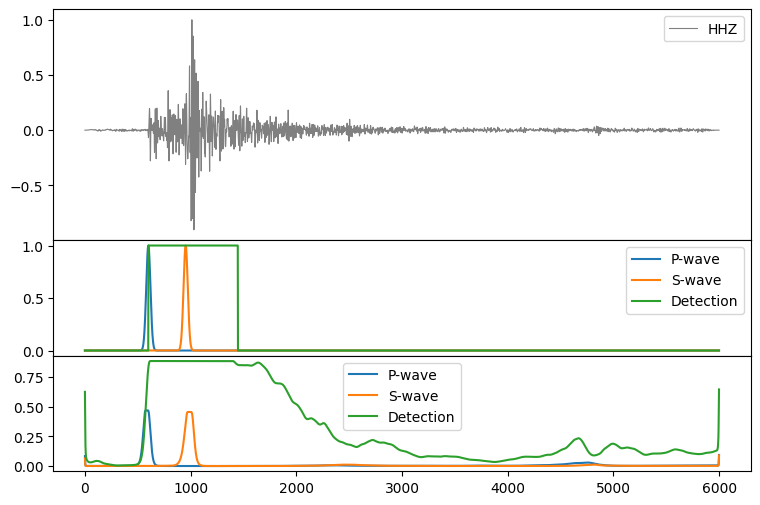

In [4]:
from swag.posteriors import SWAG

dataset = test_loader.dataset
# Get a random sample
random_index = int(np.random.random()*len(dataset))
sample = dataset[random_index]

fig = plt.figure(figsize=(9,6))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [2, 1, 1]})

axs[0].plot((sample["X"][0]/np.amax(sample["X"][0])).T, label='HHZ', linewidth=.8, color='gray')
axs[1].plot(sample["y"][:2].T, label=['P-wave','S-wave'])
axs[1].plot(sample["detections"].T, label='Detection')

weights = torch.load('.cache/checkpoint-15.pt')['state_dict']
model = EQTransformer(in_channels= 1)


model.load_state_dict(state_dict=weights, strict=False)
model.cuda()

outputs = model(torch.tensor(sample['X'][:1,:], device='cuda').unsqueeze(0))
pred =  torch.stack(outputs, dim=1).detach().cpu().numpy()[0]

pred_rearanged = np.empty(pred.shape)
pred_rearanged[0] = pred[1]
pred_rearanged[1] = pred[2]
pred_rearanged[2] = pred[0]

axs[2].plot(pred_rearanged.T, label=['P-wave','S-wave','Detection'])

print(pred)

for ax in axs:
    ax.legend()
